## Assignment 1:

In this assignment, we construct **dense neural networks** for classifying images from the `MNIST` dataset: http://yann.lecun.com/exdb/mnist/. The MNIST database consists of a set of 70,000 small (28x28 pixel) grayscale images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

>In **EXPERIMENTS 1 to 3**, we consider `dense neural network` models with one hidden layer. We start with one node in this hidden layer and progressively increase the number of (hidden) nodes in the layer until we find the "best" model in Experiment 3.

 But our goal in these `three` experiments is *not only* to find the "best" `dense neural network` model with one hidden but *also* to explore what the node(s) in the hidden layer are "detecting" and what their outputs (i.e. `activation values`) contribute to the final classification of an image. These are examples of intrinsic `global explanations` and `local explanations` , respectively, as described in this recent survey article: 

https://cacm.acm.org/magazines/2020/1/241703-techniques-for-interpretable-machine-learning/fulltext

To determine what the hidden node is "detecting" we use gradient descent to find a visual pattern that maximizes the activation value of the hidden node, i.e. the visual pattern that the hidden node is maximally responsive to. In this case, the exercise is probably not very insightful. But in `Assignment 2`  we will repeat this analysis with "clusters of nodes" (`convnet filters`) in `convolutional neural network` models. By the examining the patterns that each convnet filter is maximally responsive (but also by visualizing the convnet activations for particular test images) we should be able to determine what (some of) the filters in the `CCN` model are up to. The (activation values of the) hidden nodes (actually, groups of hidden nodes corresponding or *convnet filters*) can be visualized in various ways to show what "features" (edges, texture, etc.) of the input images they capture.

>In **EXPERIMENT 4** we use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from `Experiment 3` to 154 inputs nodes and train it on the new lower dimensional data. 

>In **EXPERIMENT 5** we use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' `dense neural network` using these 70 features and compare its performance to the the `dense neural network` models from EXPERIMENTS 3 and 4.

Here are more details for the first `three` experiments:

* **EXPERIMENT 1**: Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on `CNN` models in `Assignment 2`.

* **EXPERIMENT 2**: This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a `scatterplot`. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1`, the color clusters should have very little overlap.

**NOTE**: For EXPERIMENTS 1 & 2 we also perform the following additional tasks:
> 1. We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.
> 2. For each model we obtain the confusion matrix and use it to display sample images of true vs false positives and negatives.


* **EXPERIMENT 3**: Students can experiment with more hidden nodes (in the hidden layer) to obtain the `best` model. This `final` model will be used in EXPERIMENTS 4 & 5.


**References**:
https://github.com/fchollet/deep-learning-with-python-notebooks (2.1 & 5.4)

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
tf.__version__

'2.1.0'

In [3]:
#tf.compat.v1.disable_eager_execution() # neccessary for K.gradient to work in TensorFlow 2.x

In [4]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The MNIST dataset

The MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It comes prepackaged as part of tf.Keras. Use the `mnist.load_data()` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## EXPERIMENT  4:

We use PCA to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 200. We should reduce the number of dimensions of our 'best' model from `EXPERIMENT 3` to 200 inputs nodes and train it on the new lower dimensional data. For argument sake, We assume our 'best' model consists of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). 

We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal.

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [6]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Validating our approach

Since we will be using categorical_crossentropy as the loss function we need to use to_categorical to convert the class vector of lables to binary matrix representation. 

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [7]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with PCA decomposition.

We use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images. By setting `n_components=0.95` we get the 154 principal components that contain 95% of the variance (information) in the training images. We transform the training images to reduce its dimensionality from 784 to 154. We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. 

In [8]:
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [9]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

## Building our 'best' network (before reducing dimensions)

Recall from `Experiment 3` that our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of `85 nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(85, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))   

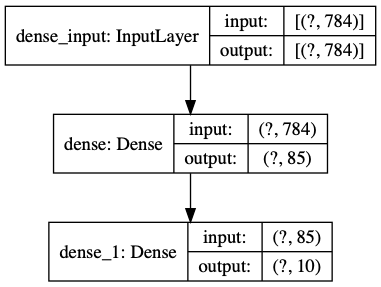

In [11]:
keras.utils.plot_model(model, "mnist_model_1hnode.png", show_shapes=True) # plot a graph of the model

In [12]:
model.summary() # prints a summary representation of the odel

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                66725     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                860       
Total params: 67,585
Trainable params: 67,585
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [13]:
# For use with non-categorical labels
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [14]:
history = model.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 49us/sample - loss: 0.2901 - accuracy: 0.9179 - val_loss: 0.1553 - val_accuracy: 0.9558
Epoch 2/30
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1440 - accuracy: 0.9570 - val_loss: 0.1136 - val_accuracy: 0.9654
Epoch 3/30
55000/55000 [==============================] - 2s 45us/sample - loss: 0.1076 - accuracy: 0.9682 - val_loss: 0.1038 - val_accuracy: 0.9694
Epoch 4/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.0860 - accuracy: 0.9749 - val_loss: 0.0980 - val_accuracy: 0.9716
Epoch 5/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.0731 - accuracy: 0.9785 - val_loss: 0.0859 - val_accuracy: 0.9750
Epoch 6/30
55000/55000 [==============================] - 4s 73us/sample - loss: 0.0625 - accuracy: 0.9821 - val_loss: 0.0884 - val_accuracy: 0.9738
Epoch 7/30
55000/55000 [==============================] -

In [15]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9978, val acc: 0.9754,
loss: 0.009097, val loss: 0.1565


## Testing the model

Evaluate the model on the test dataset.

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 24us/sample - loss: 0.1702 - accuracy: 0.9740


In [18]:
print(f'test acc: {test_acc}, test loss: {test_loss}')  # Note very good...

test acc: 0.9739999771118164, test loss: 0.17017456902856953


## Building, training and testing the model on the new data

We modify the model to take input with dimension (154,)

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(85, activation='relu', input_shape=(154,)))
model.add(layers.Dense(10, activation='softmax'))  

# For use with non-categorical labels
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit(train_images_red, train_labels, epochs=30,
                    validation_data=(val_images_red, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.3455 - accuracy: 0.9056 - val_loss: 0.1604 - val_accuracy: 0.9560
Epoch 2/30
55000/55000 [==============================] - 2s 33us/sample - loss: 0.1369 - accuracy: 0.9597 - val_loss: 0.1191 - val_accuracy: 0.9658
Epoch 3/30
55000/55000 [==============================] - 2s 39us/sample - loss: 0.0975 - accuracy: 0.9718 - val_loss: 0.1002 - val_accuracy: 0.9714
Epoch 4/30
55000/55000 [==============================] - 2s 36us/sample - loss: 0.0753 - accuracy: 0.9780 - val_loss: 0.0911 - val_accuracy: 0.9736
Epoch 5/30
55000/55000 [==============================] - 2s 35us/sample - loss: 0.0604 - accuracy: 0.9820 - val_loss: 0.0882 - val_accuracy: 0.9752
Epoch 6/30
55000/55000 [==============================] - 2s 34us/sample - loss: 0.0495 - accuracy: 0.9860 - val_loss: 0.0855 - val_accuracy: 0.9770
Epoch 7/30
55000/55000 [==============================] -

In [20]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9999, val acc: 0.974,
loss: 0.001217, val loss: 0.1739


## Testing the model

Evaluate the model on the test dataset.

In [22]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)

10000/10000 [==============================] - 0s 21us/sample - loss: 0.1879 - accuracy: 0.9729


In [23]:
print(f'test acc: {test_acc}, test loss: {test_loss}')  

test acc: 0.9728999733924866, test loss: 0.18792889942303592


# Comparison of the two models

Reducing the dimensions from 784 to 154 had no negative impact on the performance of our 'best' model.


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

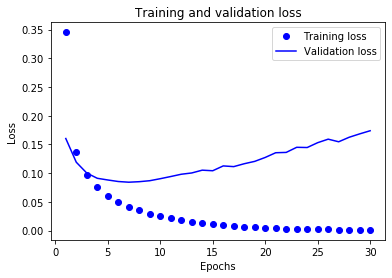

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

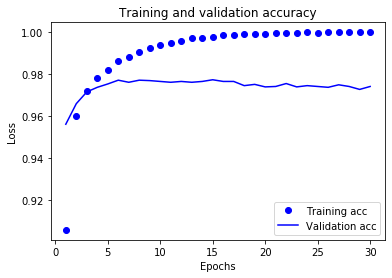

In [26]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()